In [52]:
domain = 'service'

In [53]:
import os
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from glob import glob
from operator import itemgetter
from typing import List, Tuple

import fasttext
import nltk
import numpy as np
import torch
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from tag_utils import Annotate
from tqdm import tqdm

nltk.download('stopwords')
model = fasttext.load_model('../cc.en.300.bin')
def process_ann(idx: int, sentence: str):
    result = {}
    for score, mention, entity_title, entity_id, uri in Annotate(sentence, theta=0.05).values():
        if entity_title in result:
            if len(result[entity_title]) < len(mention):
                result[entity_title] = mention
        else:
            result[entity_title] = mention
    return idx, result



entities_tuple_list = []
lines = []
# get all sentences in a domain
for file in glob(os.path.join("../data", f"{domain}.*.txt")):
    lines.extend([line.split("***") for line in open(file).read().splitlines()])
with ThreadPoolExecutor(max_workers=256) as t:
    for future in tqdm(as_completed(
        [t.submit(process_ann, idx, line[0]) for idx, line in enumerate(lines)]),
                       total=len(lines),
                       desc=f"Extracting eitities in {domain} domain"):
        entities_tuple_list.append(future.result())
# entities_tuple_list = sorted(entities_tuple_list, key=lambda item: item[0])
entities_dict_list = [entities_dict for _, entities_dict in entities_tuple_list]
# remove stopwords
sets = stopwords.words('english')
entities = [word for entities_dict in entities_dict_list for word in entities_dict.values() if word not in sets]
counters = Counter(entities)
sorted_entities: List[Tuple[str, int]] = sorted(filter(lambda item: item[1] > 0, counters.items()),
                                                key=lambda item: item[1],
                                                reverse=True)
vec_dict = {}
for entity in tqdm(sorted_entities, total=len(counters)):
    e = entity[0]
    vec_dict[e] = model.get_word_vector(e)
getter = itemgetter(*[entity for entity, _ in sorted_entities[:10]])
mean_vec = np.average(getter(vec_dict),
                      axis=0,
                      weights=[count for _, count in sorted_entities[:10]])
res = np.array([
        cosine_similarity(mean_vec.reshape(1, -1), vec_dict[k].reshape(1, -1)) for k in vec_dict
    ]).squeeze()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 2853/2853 [00:00<00:00, 52758.42it/s]


In [54]:
aspects = []
for line in lines:
    text, labels = line
    tokens = text.split()
    labels = labels.split()
    aspect = []
    for idx, label in enumerate(labels):
        if label != 'O':
            aspect.append(tokens[idx])
            continue
        if aspect:
            aspects.append(' '.join(aspect))
            aspect.clear()
len(set(aspects))

884

In [55]:
res.shape[0]

2853

In [56]:
# topk = torch.topk(torch.from_numpy(res), int(0.9 * res.shape[0])).indices.tolist()
# k = len([sim for sim in itemgetter(*topk)(res) if sim > 0.0])
# topk = torch.topk(torch.from_numpy(res), k).indices.tolist()
topk = torch.topk(torch.from_numpy(res), res.shape[0]).indices.tolist()
len(set(aspects).intersection(set([item[0] for item in itemgetter(*topk)(sorted_entities)]))) / len(
    set(aspects))

0.5147058823529411

In [57]:
len(set(aspects).intersection(set([item[0] for item in itemgetter(*topk)(sorted_entities)])))/res.shape[0]

0.15948124780932352

In [58]:
sorted_entities

[('E*Trade', 105),
 ('UOP', 91),
 ('people', 83),
 ('Egroups', 83),
 ('eGroups', 83),
 ('time', 73),
 ('good', 68),
 ('service', 66),
 ('CTU', 63),
 ('E - Trade', 61),
 ('Etrade', 60),
 ('one', 56),
 ('email', 53),
 ('egroups', 52),
 ('customer service', 51),
 ('experience', 51),
 ('UMUC', 47),
 ('school', 47),
 ('students', 44),
 ('classes', 44),
 ('Capella', 44),
 ('online', 41),
 ('Yahoo', 41),
 ('account', 40),
 ('money', 39),
 ('education', 38),
 ('work', 36),
 ('information', 36),
 ('groups', 35),
 ('E*trade', 35),
 ("n't", 35),
 ('program', 34),
 ('group', 34),
 ('research', 33),
 ('instructors', 32),
 ('think', 30),
 ('I am', 30),
 ('free', 29),
 ('UoP', 29),
 ('features', 29),
 ('friends', 24),
 ('times', 24),
 ('student', 24),
 ('lists', 23),
 ('problem', 23),
 ('E*TRADE', 23),
 ('nice', 23),
 ('degree', 23),
 ('list', 22),
 ('well', 22),
 ('trading', 22),
 ('trade', 21),
 ('read', 21),
 ('first', 21),
 ('ETrade', 20),
 ('lot', 20),
 ('Online', 20),
 ('fact', 20),
 ('class', 

In [59]:
entities

['yes',
 'ETrade',
 'customer service',
 'minutes',
 'hour',
 'UOP',
 'in it for the money',
 'success',
 'students',
 'DeVry',
 'get high',
 'return',
 'classes',
 'students',
 'reading',
 'elementary school',
 'level',
 'plus',
 'E*Trade',
 'nothing',
 'good',
 'experience',
 'eGroups.com',
 'lot',
 'happier',
 'Customer service',
 'websites',
 'advertising',
 'E*Trade',
 'cost',
 'education',
 'MBA',
 'CTU',
 'depressing',
 'thought',
 'people',
 'undergraduate',
 'degrees',
 'UMUC',
 'bad',
 'DeVry',
 "that 's when I knew",
 'big',
 'If',
 'fast',
 'connection',
 'matter',
 'ETrade',
 'fast',
 'loading',
 'pages',
 'in touch',
 'nephews',
 'cousins',
 'aunts',
 'uncles',
 'the best',
 'FREE',
 'Monday',
 'paper',
 'get it together',
 'Class',
 'material',
 'weak',
 'instructors',
 'think',
 'message',
 'polls',
 'feature',
 'friends',
 'process',
 'but not',
 'E - Trade',
 'personalize',
 'Web page',
 'mix',
 'investment',
 'news',
 'research',
 'portfolio',
 'communicate',
 'write

In [60]:
len(set(aspects).intersection(set(entities)))/len(set(aspects))

0.5147058823529411

In [61]:
data = open(f"../data/{domain}.test.txt", "r").read().splitlines()
with open("/root/autodl-tmp/out/bert_base/laptop-rest/predict.txt", "r") as f:
    pre_aspects = []
    for i, line in enumerate(f):
        _, pre, labels = line.split("***")
        tokens = data[i].split("***")[0]
        pres = pre.split()
        labels = labels.strip().split()
        pre_aspect = []
        for idx, label in enumerate(pres):
            if label != 'O':
                pre_aspect.append(tokens[idx])
                continue
            if pre_aspect:
                pre_aspects.append(' '.join(pre_aspect))
                pre_aspect.clear()
len(set(pre_aspects))

FileNotFoundError: [Errno 2] No such file or directory: '/root/autodl-tmp/out/bert_base/laptop-rest/predict.txt'

In [ ]:
len(set(pre_aspects).intersection(set(entities)))/len(set(pre_aspects))

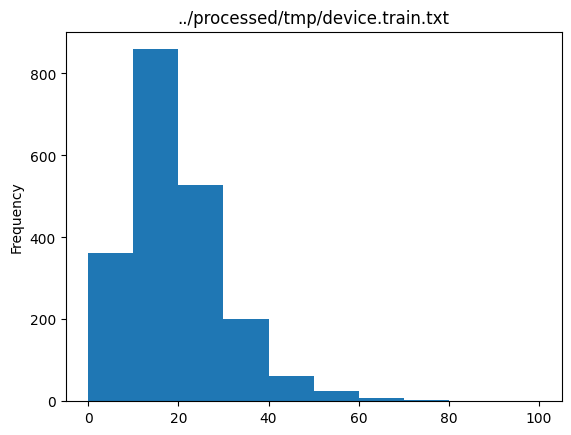

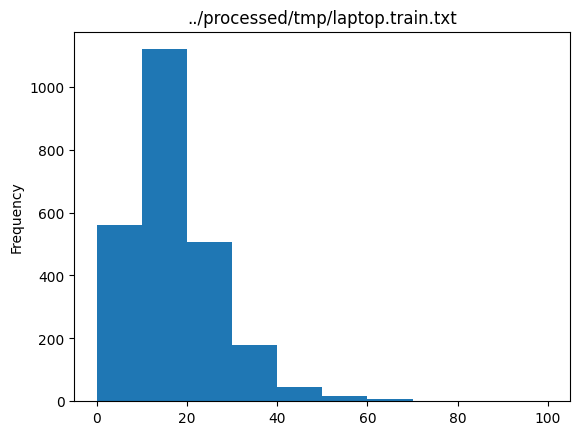

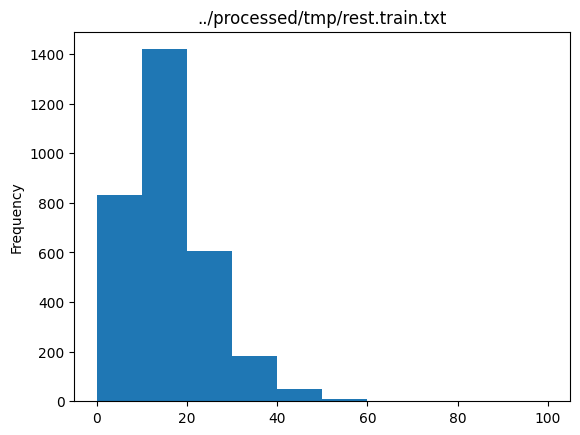

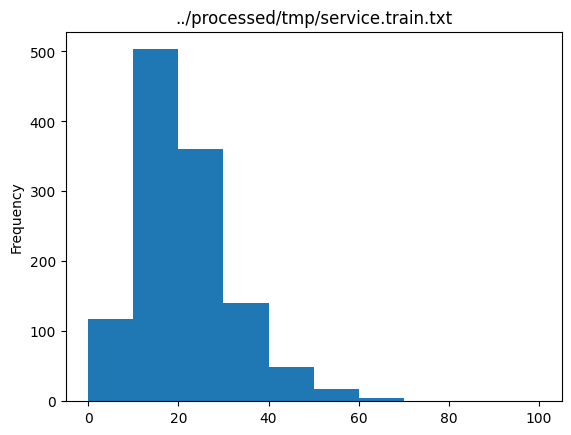

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
for file in glob("../processed/tmp/*.train.txt"):
    lines = []
    with open(file, "r") as f:
        for line in f:
            text, labels = line.split("***")
            lines.append(text)
    data = pd.DataFrame(lines, columns=['text'])
    data['length'] = data['text'].str.split(' ').str.len()
    plt.title(file)
    data['length'].plot.hist(bins=[i for i in range(0, 101) if i % 10 == 0])
    plt.show()

In [1]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
tokenizer.convert_ids_to_tokens([101, 1998, 2009, 2035, 2272])


['[CLS]', 'and', 'it', 'all', 'come']